# AVISO : Interpolation avec le datacube

Après avoir réalisé des tests de colocalisation, nous allons réaliser des interpolations entre les données d'observations et le datacube.

In [1]:
import os
import dask
import intake
import numpy as np
import pandas as pd
import xarray as xr
import dask_jobqueue
import dask.distributed

from pathlib import Path

## Cluster Dask

In [3]:
# Création du cluster Dask
cluster = dask_jobqueue.PBSCluster(queue='mpi', 
                                   cores=8,
                                   memory="115GB",
                                   walltime="04:00:00",
                                   interface='ib0',
                                   local_directory='/tmp',
                                   log_directory='/home1/scratch/gcaer/dask-logs',
                                   processes=1,
                                  )
cluster.scale(jobs=7)

In [4]:
client = dask.distributed.Client(cluster, timeout=600)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.123:8787/status,
Dashboard: http://10.148.1.123:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.123:33819,Workers: 0
Dashboard: http://10.148.1.123:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
port = client.scheduler_info()["services"]["dashboard"]
ssh_command = f'ssh -N -L {port}:{os.environ["HOSTNAME"]}:{port} {os.environ["USER"]}@datarmor.ifremer.fr'

print(f"{ssh_command}")
print(f"open browser at address of the type: http://localhost:{port}")

ssh -N -L 8787:r2i2n25:8787 gcaer@datarmor.ifremer.fr
open browser at address of the type: http://localhost:8787


## Ouverture du datacube

In [6]:
# Chemin vers le datacube
wrk = Path('/home/datawork-data-terra/odatis/data')
name = 'aviso'
version = 'datacube-year'
output = wrk / name / version

In [7]:
%%time
# Ouverture du datacube
start, end = 2018, 2020
chunks = {"time": 1, "latitude": -1, "longitude": -1}
vars = ["crs","lat_bnds","lon_bnds","ugosa","err_ugosa","vgosa","err_vgosa","ugos","vgos","flag_ice","tpa_correction","nv",]
cat = intake.open_catalog(output / "reference.yaml")
datacubes = [cat[str(year)](chunks=chunks).to_dask().drop_vars(vars) for year in range(start, end+1)]
datacube = xr.concat(datacubes, dim="time")

/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


CPU times: user 20.6 s, sys: 2.3 s, total: 22.9 s
Wall time: 29.5 s


/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


## Ouverture des matchups

In [8]:
# Ouverture des matchups
label = 'gps_Jason-3_2019'
#label = 'argos_Jason-3_2019'
zarr_dir = Path("/home/datawork-lops-osi/aponte/margot/historical_coloc")
ds_raw = xr.open_zarr(zarr_dir / f'{label}.zarr')

## Initialise les matchups

In [9]:
dt = (-2, 3) # +/- Nombre de jour à extraire autour des points d'observations (+/- 2 jour)

In [10]:
def initialisation(ds, **kwargs):
    """Inialisation du dataset de matchup, afin de préparer l'étape de pré-traitement."""
    
    # Sélection des matchups avec une distance inférieur à 200km ? 
    ds = ds.where(ds_raw.alti___distance.compute()<2e5, drop=True)
    
    vars = [
        '__site_id','__site_name','alti___distance','alti___source','alti___source_center_index','alti___source_slices',
        'alti___time_difference','alti_cycle','alti_dac','alti_ggx_dac','alti_ggx_internal_tide','alti_ggx_mdt','alti_ggx_ocean_tide',
        'alti_ggx_sla_filtered','alti_ggx_sla_unfiltered','alti_ggx_sla_unfiltered_denoised','alti_ggx_sla_unfiltered_denoised_uncertainty',
        'alti_ggx_sla_unfiltered_imf1','alti_ggx_sla_unfiltered_noise','alti_internal_tide', 'alti_lwe','alti_mdt','alti_ocean_tide',
        'alti_sla_filtered','alti_sla_unfiltered','alti_sla_unfiltered_denoised','alti_sla_unfiltered_denoised_uncertainty','alti_sla_unfiltered_imf1',
        'alti_sla_unfiltered_noise','alti_tpa_correction','alti_track','box_latc','box_lonc','box_phi','box_theta_lat','box_theta_lon',
        'drifter_WMO','drifter_acc_x','drifter_acc_y','drifter_coriolis_x','drifter_coriolis_y','drifter_deploy_date','drifter_deploy_lat',
        'drifter_deploy_lon','drifter_drogue_lost_date','drifter_end_date','drifter_end_lat','drifter_end_lon','drifter_err_lat','drifter_err_lon',
        'drifter_err_ve','drifter_err_vn','drifter_expno','drifter_gap','drifter_lon360','drifter_rowsize','drifter_theta_lat','drifter_theta_lon',
        'drifter_typebuoy','drifter_typedeath','drifter_ve', 'drifter_vn','drifter_vx', 'drifter_vy','f','alti_time_mid', 
        'alti_x','alti_x_mid','alti_y','alti_y_mid']

    # Suppression des variables sans intérets
    ds = ds.drop_vars(vars)

    # Pour chaque observation, définition de l'extension temporelle
    ds['time_min'] = (ds.time + np.timedelta64(kwargs['dt'][0], 'D'))
    ds['time_max'] = (ds.time + np.timedelta64(kwargs['dt'][1]-1, 'D'))
    return ds

## Pré-traitements des matchups

In [11]:
_lon_180_to_360 = lambda lon: lon % 360

def limite_lon(boxs, drifters):
    """ Fonction universel (ufunc) qui créé un mask pour les observations avec une longitude en dehors 
    de la plage [-178:178] """
    limite_lons = []
    for box, drifter in zip(boxs, drifters):
        limite_lon = ((drifter > 178).any() or (drifter < -178).any() or (box > 178).any() or (box < -178).any())
        if limite_lon: 
            limite_lons.append(True)
        else:
            limite_lons.append(False)
    return np.array(limite_lons)

def lon_180_to_360(values, limits):
    """ Fonction universelle (ufunc) qui pour chaque observation, convertis les valeurs de longitudes 
    de la plage [-180:180] à [0:360], si les valeurs de longitude sont en dehors de la plage [-178:178]. """
    new_values = []
    for value, limit in zip(values, limits):
        if limit:
            new_values.append(_lon_180_to_360(value))
        else:
            new_values.append(value)
    return np.array(new_values)

def lon_180_to_360_alti(values, limits, **kwargs):
    """ Fonction universelle (ufunc) qui pour chaque observation, convertis les valeurs de alti_lon 
    de la plage [-180:180] à [0:360], si les valeurs de longitude sont en dehors de la plage [-178:178]. """
    new_values = []
    for value, limit in zip(values, limits):
        if limit:
            new_values.append(_lon_180_to_360(value[kwargs['idx']]))
        else:
            new_values.append(value[kwargs['idx']])
    return np.array(new_values)

def mask_drifter_time(drifter_times, times, **kwargs):
    """ Fonction universelle (ufunc) qui pour chaque observation créé un mask pour les valeurs de drifter_time qui sont
    dans la plage +/- dt jour autour de la valeur de time. """
    values = []
    for drifter_time, time in zip(drifter_times, times):
        t = pd.to_datetime(time)
        start = np.datetime64((t + pd.Timedelta(days=kwargs['dt'][0])).date())
        end = np.datetime64((t + pd.Timedelta(days=kwargs['dt'][1]-1)).date())
        mask = (drifter_time >= start) & (drifter_time <= end)
        drifter_time[~mask] = np.datetime64('NaT')
        drifter_time.astype(np.int64)
        values.append(drifter_time)
    return np.array(values)

def set_time_array(times, **kwargs):
    """ Fonction universelle (ufunc) qui pour chaque observation, génère une liste de date qui sont dans 
    la plage +/- dt jour autour de la valeur de time. """
    values = []
    for time in zip(times):
        t = pd.to_datetime(time)
        t = [np.datetime64((t + pd.Timedelta(days=_dt)).date[0]) for _dt in range(*kwargs['dt'])]
        values.append(t)
    return np.array(values).astype(np.int64)
    
def min_apply(boxs, drifters):
    """ Fonction universelle (ufunc) qui pour chaque observation recupère la valeur minimale de longitude/latitude entre box et drifter. """
    return np.array([min(box.min(), drifter.min()) for box, drifter in zip(boxs, drifters)])

def max_apply(boxs, drifters):
    """ Fonction universelle (ufunc) qui pour chaque observation recupère la valeur maximale de longitude/latitude entre box et drifter. """
    return np.array([max(box.max(), drifter.max()) for box, drifter in zip(boxs, drifters)])

In [12]:
def set_limite_lon(ds):
    # Créé un mask des observation avec une valeur de longitude (box_lon, drifter_lon) en dehors de la plage [-178:178]
    ds['limite_lon'] = xr.apply_ufunc(
        limite_lon, 
        ds["box_lon"], 
        ds["drifter_lon"],
        input_core_dims=[['box_x', 'box_y'], ['site_obs']],
        output_core_dims=[[]],
        output_dtypes=[bool],
        dask='parallelized'
    )
    return ds

def set_new_box_lon(ds):
    # Conversion des valeurs de box_lon de la plage [-180:180] à [0:360] pour les observations dont limite_lon = True
    ds['new_box_lon'] = xr.apply_ufunc(
        lon_180_to_360, 
        ds["box_lon"], 
        ds["limite_lon"],
        input_core_dims=[['box_y', 'box_x'], []],
        output_core_dims=[['box_y', 'box_x']],
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={'box_y':80, 'box_x':120}),
        dask='parallelized'
    )
    return ds

def set_new_drifter_lon(ds):
    # Conversion des valeurs de drifter_lon de la plage [-180:180] à [0:360] pour les observations dont limite_lon = True
    ds['new_drifter_lon'] = xr.apply_ufunc(
        lon_180_to_360, 
        ds["drifter_lon"], 
        ds["limite_lon"],
        input_core_dims=[['site_obs'], []],
        output_core_dims=[['site_obs']],
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={'site_obs': ds.sizes['site_obs']}),
        dask='parallelized'
    )
    return ds

def set_new_alti_lon(ds):
    # Conversion des valeurs de alti_lon de la plage [-180:180] à [0:360] pour les observations dont limite_lon = True
    ds['new_alti_lon'] = xr.apply_ufunc(
        lon_180_to_360_alti, 
        ds["alti_lon"], 
        ds["limite_lon"],
        input_core_dims=[['alti_time'], []],
        output_core_dims=[[]],
        output_dtypes=[float],
        dask='parallelized',
        kwargs={'idx': ds.sizes['alti_time']//2}
    )
    return ds

def set_new_drifter_time(ds, dt):
    # Sélection des valeurs de drifter_time qui sont dans la plage +/- dt jour autour de la valeur de time.
    ds['new_drifter_time'] = xr.apply_ufunc(
        mask_drifter_time, 
        ds["drifter_time"].chunk(dict(site_obs=-1)), 
        ds["time"],
        input_core_dims=[['site_obs'], []],
        output_core_dims=[['site_obs']],
        output_dtypes=[int],
        dask_gufunc_kwargs=dict(output_sizes={'site_obs': ds.sizes['site_obs']}),
        dask='parallelized',
        kwargs={'dt': dt} # +/- 2 jours
    ).astype('datetime64[ns]')
    return ds

def set_new_drifter_time_array(ds, dt):
    # Création d'une liste de date qui sont dans la plage +/- dt jour autour de la valeur de time.
    ds['_drifter_time_array'] = xr.apply_ufunc(
        set_time_array, 
        ds["time"],
        input_core_dims=[[]],
        output_core_dims=[['t']],
        output_dtypes=[int],
        dask_gufunc_kwargs=dict(output_sizes={'t': len(range(*dt))}),
        dask='parallelized',
        kwargs={'dt': dt} # +/- 2 jours
    ).astype('datetime64[D]').astype('datetime64[ns]')
    return ds

def set_matchup_site(ds):
    # Récupération des valeurs de longitude, latitude et temps des bouées dérivantes
    ds_obs_m = ds.isel(site_obs=xr.DataArray(ds.__site_matchup_indice.values.astype(int), dims='obs'))
    ds['_drifter_lon'] = ds_obs_m['new_drifter_lon']
    ds['_drifter_lat'] = ds_obs_m['drifter_lat']
    ds['_drifter_time'] = ds_obs_m['drifter_time']
    return ds

def set_lon_min(ds):
    # Récupère la valeur de longitude minimale entre new_box_lon et new_drifter_lon
    ds['lon_min'] = xr.apply_ufunc(
        min_apply, 
        ds["new_box_lon"], 
        ds["new_drifter_lon"],
        input_core_dims=[['box_y', 'box_x'], ['site_obs']],
        output_core_dims=[[]],
        output_dtypes=[float],
        dask='parallelized',
    )
    return ds

def set_lon_max(ds):
    # Récupère la valeur de longitude maximale entre new_box_lon et new_drifter_lon
    ds['lon_max'] = xr.apply_ufunc(
        max_apply, 
        ds["new_box_lon"], 
        ds["new_drifter_lon"],
        input_core_dims=[['box_y', 'box_x'], ['site_obs']],
        output_core_dims=[[]],
        output_dtypes=[float],
        dask='parallelized',
    )
    return ds

def set_lat_min(ds):
    # Récupère la valeur de latitude minimale entre new_box_lat et new_drifter_lat
    ds['lat_min'] = xr.apply_ufunc(
        min_apply, 
        ds["box_lat"], 
        ds["drifter_lat"],
        input_core_dims=[['box_y', 'box_x'], ['site_obs']],
        output_core_dims=[[]],
        output_dtypes=[float],
        dask='parallelized',
    )
    return ds

def set_lat_max(ds):
    # Récupère la valeur de latitude maximale entre new_box_lat et new_drifter_lat
    ds['lat_max'] = xr.apply_ufunc(
        max_apply, 
        ds["box_lat"], 
        ds["drifter_lat"],
        input_core_dims=[['box_y', 'box_x'], ['site_obs']],
        output_core_dims=[[]],
        output_dtypes=[float],
        dask='parallelized',
    )
    return ds

In [13]:
def interp_traj(datacube, ds):
    # DRIFTER TRAJECTORY
    res_traj = (
        datacube
        .interp(
            time=ds.new_drifter_time,
            longitude=ds['new_drifter_lon'],
            latitude=ds['drifter_lat'],
            )
        .rename({v: "aviso_traj_" + v for v in datacube})
        .drop_vars(
            [
                "drifter_lon",
                "drifter_lat",
                "time",
                "longitude",
                "latitude",
                "lat",
                "lon",
                "time",
            ]
        )
    )
    return res_traj

def interp_box(datacube, ds):
    # BOX
    res_box = (
        datacube
        .interp(
            time=ds._drifter_time,
            longitude=ds.new_box_lon,
            latitude=ds.box_lat,
        )
        .drop_vars(["longitude", "latitude", "lat", "lon", "time"])
        .rename({v: "aviso_box_" + v for v in datacube})
    )
    return res_box

def interp_drifter(datacube, ds):
    # DRIFTER MATCHUP POSITION
    res_drifter = (
        datacube
        .interp(
            time=ds['_drifter_time_array'],
            longitude=ds['_drifter_lon'],#.drop_vars(['time']), 
            latitude=ds['_drifter_lat'],#.drop_vars(['time']),
        )
    )
    res_drifter['aviso_time_'] = ds['_drifter_time_array']
    res_drifter = (
        res_drifter.set_coords(['aviso_time_'])
        .drop_vars(["longitude", "latitude", "lat", "lon", "time"])
        .rename({v: "aviso_drifter_temp_" + v for v in datacube})
        .rename({'t': 'aviso_time'})
    )
    return res_drifter

def interp_alti(datacube, ds):
    # ALTI
    res_alti = (
        datacube
        .interp(
            time=ds['alti_time_'].isel(alti_time=ds.sizes['alti_time']//2),
            longitude=ds['new_alti_lon'],
            latitude=ds['alti_lat'].isel(alti_time=ds.sizes['alti_time']//2),
        )
    )
    res_alti = res_alti.drop_vars(list(res_alti.coords.keys())).rename(
        {v: "aviso_alti_matchup_" + v for v in datacube}
    )
    return res_alti

def merge_results(ds, res_traj, res_box, res_drifter, res_alti):
    g = 9.81

    res_box["aviso_box_ggx_sla"] = g * res_box["aviso_box_sla"].differentiate(
        "box_x"
    )
    res_box["aviso_box_ggy_sla"] = g * res_box["aviso_box_sla"].differentiate(
        "box_y"
    )
    res_traj["aviso_traj_ggx_sla"] = res_box["aviso_box_ggx_sla"].interp(
        box_x=res_traj.drifter_x, box_y=res_traj.drifter_y
    )
    res_traj["aviso_traj_ggy_sla"] = res_box["aviso_box_ggy_sla"].interp(
        box_x=res_traj.drifter_x, box_y=res_traj.drifter_y
    )
    # adt
    res_box["aviso_box_ggx_adt"] = g * res_box["aviso_box_adt"].differentiate(
        "box_x"
    )
    res_box["aviso_box_ggy_adt"] = g * res_box["aviso_box_adt"].differentiate(
        "box_y"
    )
    res_traj["aviso_traj_ggx_adt"] = res_box["aviso_box_ggx_adt"].interp(
        box_x=res_traj.drifter_x, box_y=res_traj.drifter_y
    )
    res_traj["aviso_traj_ggy_adt"] = res_box["aviso_box_ggy_adt"].interp(
        box_x=res_traj.drifter_x, box_y=res_traj.drifter_y
    )

    # sla
    res_alti["aviso_alti_matchup_ggx_sla"] = res_box["aviso_box_ggx_sla"].sel(
        box_x=0, box_y=0
    )
    res_alti["aviso_alti_matchup_ggy_sla"] = res_box["aviso_box_ggy_sla"].sel(
        box_x=0, box_y=0
    )
    # adt
    res_alti["aviso_alti_matchup_ggx_adt"] = res_box["aviso_box_ggx_adt"].sel(
        box_x=0, box_y=0
    )
    res_alti["aviso_alti_matchup_ggy_adt"] = res_box["aviso_box_ggy_adt"].sel(
        box_x=0, box_y=0
    )

    res_drifter_matchup = res_traj[[v for v in res_traj if "gg" in v]].isel(
    site_obs=xr.DataArray(ds.__site_matchup_indice.values.astype(int), dims='obs')
    )
    res_drifter_matchup = res_drifter_matchup.rename(
        {v: v.replace("traj_", "drifter_matchup_") for v in res_drifter_matchup}
    ).drop_vars(
        list(res_drifter_matchup.coords.keys())
    )  # NEW

    res = (
        xr.merge([res_traj, res_drifter_matchup, res_box, res_drifter, res_alti])
            #.reset_index("aviso_time")
            .reset_coords(["drifter_time", "drifter_x", "drifter_y", "aviso_time_"])
    )

    res = res.set_coords(
            ["obs", "aviso_time_"]
        )
    return res

def set_attrs(res):
    # attrs
    res.aviso_alti_matchup_err_sla.attrs = {
        "description": "sla error interpolated on the altimeter's matchup",
        "long_name": r"$err\eta_{altimatchup}$",
        "units": "m",
    }
    res.aviso_alti_matchup_sla.attrs = {
        "description": "sla interpolated on the altimeter's matchup",
        "long_name": r"$\eta_{altimatchup}$",
        "units": "m",
    }
    res.aviso_alti_matchup_adt.attrs = {
        "description": "adt interpolated on the altimeter's matchup",
        "long_name": r"$adt_{altimatchup}$",
        "units": "m",
    }
    res.aviso_alti_matchup_ggx_sla.attrs = {
        "description": "along track sla gradient term interpolated on the altimeter's matchup",
        "long_name": r"$g\partial_x\eta_{altimatchup}$",
        "units": r"$m.s^{-2}$",
    }
    res.aviso_alti_matchup_ggy_sla.attrs = {
        "description": "cross track sla gradient term interpolated on the altimeter's matchup",
        "long_name": r"$g\partial_y\eta_{altimatchup}$",
        "units": r"$m.s^{-2}$",
    }
    res.aviso_alti_matchup_ggx_adt.attrs = {
        "description": "along track adt gradient term interpolated on the altimeter's matchup",
        "long_name": r"$g\partial_xadt_{altimatchup}$",
        "units": r"$m.s^{-2}$",
    }
    res.aviso_alti_matchup_ggy_adt.attrs = {
        "description": "cross track adt gradient term interpolated on the altimeter's matchup",
        "long_name": r"$g\partial_yadt_{altimatchup}$",
        "units": r"$m.s^{-2}$",
    }

    res.aviso_box_err_sla.attrs = {
        "description": "sla error interpolated on the box at the matchup time or for several times (depending on the dimension)",
        "long_name": r"$err\eta_{box}$",
        "units": "m",
    }
    res.aviso_box_sla.attrs = {
        "description": "sla interpolated on the box at the matchup time or for several times (depending on the dimension)",
        "long_name": r"$\eta_{box}$",
        "units": "m",
    }
    res.aviso_box_ggx_sla.attrs = {
        "description": "along track sla gradient term interpolated on the box at the matchup time or for several times (depending on the dimension)",
        "long_name": r"$g\partial_x\eta_{box}$",
        "units": r"$m.s^{-2}$",
    }
    res.aviso_box_ggy_sla.attrs = {
        "description": "cross track sla gradient term interpolated on the box at the matchup time or for several times (depending on the dimension)",
        "long_name": r"$g\partial_y\eta_{box}$",
        "units": r"$m.s^{-2}$",
    }
    res.aviso_box_adt.attrs = {
        "description": "adt interpolated on the box at the matchup time or for several times (depending on the dimension)",
        "long_name": r"$adt_{box}$",
        "units": "m",
    }
    res.aviso_box_ggx_adt.attrs = {
        "description": "along track adt gradient term interpolated on the box at the matchup time or for several times (depending on the dimension)",
        "long_name": r"$g\partial_xadt_{box}$",
        "units": r"$m.s^{-2}$",
    }
    res.aviso_box_ggy_adt.attrs = {
        "description": "cross track adt gradient term interpolated on the box at the matchup time or for several times (depending on the dimension)",
        "long_name": r"$g\partial_yadt_{box}$",
        "units": r"$m.s^{-2}$",
    }

    res.aviso_traj_err_sla.attrs = {
        "description": "sla error interpolated on the drifter's trajectory",
        "long_name": r"$err\eta_{traj}$",
        "units": "m",
    }
    res.aviso_traj_sla.attrs = {
        "description": "sla interpolated on the drifter's trajectory",
        "long_name": r"$\eta_{traj}$",
        "units": "m",
    }
    res.aviso_traj_ggx_sla.attrs = {
        "description": "along track sla gradient term interpolated on the drifter's trajectory",
        "long_name": r"$g\partial_x\eta_{traj}$",
        "units": r"$m.s^{-2}$",
    }
    res.aviso_traj_ggy_sla.attrs = {
        "description": "cross track sla gradient term interpolated on the drifter's trajectory",
        "long_name": r"$g\partial_y\eta_{traj}$",
        "units": r"$m.s^{-2}$",
    }
    res.aviso_traj_adt.attrs = {
        "description": "adt interpolated on the drifter's trajectory",
        "long_name": r"$adt_{traj}$",
        "units": "m",
    }
    res.aviso_traj_ggx_adt.attrs = {
        "description": "along track adt gradient term interpolated on the drifter's trajectory",
        "long_name": r"$g\partial_xadt_{traj}$",
        "units": r"$m.s^{-2}$",
    }
    res.aviso_traj_ggy_adt.attrs = {
        "description": "cross track adt gradient term interpolated on the drifter's trajectory",
        "long_name": r"$g\partial_yadt_{traj}$",
        "units": r"$m.s^{-2}$",
    }

    res.aviso_drifter_matchup_ggx_sla.attrs = {
        "description": "along track sla gradient term interpolated on the drifter's matchup",
        "long_name": r"$g\partial_x\eta_{driftermatchup}$",
        "units": r"$m.s^{-2}$",
    }
    res.aviso_drifter_matchup_ggy_sla.attrs = {
        "description": "cross track sla gradient term interpolated on the drifter's matchup",
        "long_name": r"$g\partial_y\eta_{altimetermatchup}$",
        "units": r"$m.s^{-2}$",
    }
    res.aviso_drifter_matchup_ggx_adt.attrs = {
        "description": "along track adt gradient term interpolated on the drifter's matchup",
        "long_name": r"$g\partial_xadt_{driftermatchup}$",
        "units": r"$m.s^{-2}$",
    }
    res.aviso_drifter_matchup_ggy_adt.attrs = {
        "description": "cross track adt gradient term interpolated on the drifter's matchup",
        "long_name": r"$g\partial_yadt_{altimetermatchup}$",
        "units": r"$m.s^{-2}$",
    }

    res.aviso_drifter_temp_err_sla.attrs = {
        "description": "sla error interpolated on the drifter's matchup position for several times (static but temporal variation)",
        "long_name": r"$err\eta_{driftertemporal}$",
        "units": "m",
    }
    res.aviso_drifter_temp_sla.attrs = {
        "description": "sla interpolated on the drifter's matchup position for several times (static but temporal variation)",
        "long_name": r"$\eta_{driftertemporal}$",
        "units": "m",
    }
    res.aviso_drifter_temp_adt.attrs = {
        "description": "adt interpolated on the drifter's matchup position for several times (static but temporal variation)",
        "long_name": r"$adt_{driftertemporal}$",
        "units": "m",
    }
    
    # New 
    
    res.box_x.attrs = {
        'description': 
        'along track direction x coordinate of the box', 
        'units': 'm'
    }
    res.box_y.attrs = {
        'description': 'cross track direction y coordinate of the box', 
        'units': 'm'
    }
    res.drifter_time.attrs = {
        'description': "drifter's trajectory time measurements"
    }
    res.drifter_x.attrs = {
        'description': "drifter's along track direction x position on the box",
        'units': 'm'
    }
    res.drifter_y.attrs = {
        'description': "drifter's cross track direction y position on the box",
        'units': 'm'
    }
    res.aviso_time_.attrs = {
        'axis': 'T', 
        'long_name': 'Time', 
        'standard_name': 'time'
    }
    return res

In [14]:
def interpolation(datacube, ds, is_360=False):
    """Interpolation avec le datacube"""
    _lon_180_to_360 = lambda lon: lon % 360
    
    if is_360 == True:
        datacube = datacube.assign_coords(longitude=_lon_180_to_360(datacube.longitude))
        datacube = datacube.sortby("longitude")    
    
    res_traj = interp_traj(datacube, ds)
    res_box = interp_box(datacube, ds)
    res_drifter = interp_drifter(datacube, ds)
    res_alti = interp_alti(datacube, ds)
    res = merge_results(ds, res_traj, res_box, res_drifter, res_alti)
    res = set_attrs(res)
    return res

In [15]:
def preprocessing(ds, dt):
    """Pré-traitement du dataset des matchups"""
    # Preprocessing des données d'observations
    ds = set_limite_lon(ds)
    ds = set_new_box_lon(ds)
    ds = set_new_drifter_lon(ds)
    ds = set_new_alti_lon(ds)
    ds = set_new_drifter_time(ds, dt)
    ds = set_new_drifter_time_array(ds, dt)
    ds = set_matchup_site(ds)
    ds = set_lon_min(ds)
    ds = set_lon_max(ds)
    ds = set_lat_min(ds)
    ds = set_lat_max(ds)
    return ds

In [16]:
@dask.delayed
def processing(ds, datacube, dt):
    """Traitement entre les données du dataset des matchups et le datacube, 
    avec interpolation selon limite_lon = True or False et concaténation"""
    # Préparation des points d'observations (preprocessing)
    ds = preprocessing(ds, dt=dt)

    # Séparation des points avec limite_lon True or False (car traitement différents)
    ds_180 = ds.where(ds.limite_lon.compute() == False, drop=True)
    ds_360 = ds.where(ds.limite_lon.compute() == True, drop=True)

    # Interpolations et traitements
    res_180 = interpolation(datacube, ds_180)
    res_360 = interpolation(datacube, ds_360, is_360=True)

    # Concaténation des résultats pour limite_lon True or False
    res = xr.merge([res_180, res_360])

    return res

In [17]:
@dask.delayed
def concat(i, results, output, filename):
    """Concaténation des batches, et sauvegarde sur disque"""
    r = dask.compute(*results)
    res = xr.concat(r, "obs")
    
    res.to_netcdf(output / f'{filename}_{i}.nc')

In [18]:
def conf(ds, n_obs, n_batch):
    """Visualisation des paramètres (nombre de fichiers de sorties, ..) en fonction de la configuration d'entrée"""
    n_batches = ds.sizes['obs']//n_obs + 1 # Nombre de batch au total
    n_netcdf = n_batches//n_batch + 1 # Nombre de fichier netCDF en sortie
    print(f"Nombre d'observation par batch: {n_obs}")
    print(f"Nombre de batch: {n_batches}")
    print(f"Nombre de batch par fichier netCDF: {n_batch}")
    print(f"Nombre de fichier NetCDF: {n_netcdf}")
    print(f"Nombre d'observations par fichier NetCDF: {n_obs*n_batch}")

In [19]:
def recipe(ds, datacube, dt, n_obs, n_batch, output, filename):
    """Création des recettes en lazy_mode
    n_obs : Nombre d'observation par batch
    n_batch : Nombre de batch par fichier netCDF
    """

    batches = []
    n_batches= ds.sizes['obs']//n_obs + 1
    for i in range(n_batches):
        # Sélection des observation dans la tranche
        ds_sub = ds.isel(obs=slice(i*n_obs, (i+1)*n_obs))
        time_min, time_max = ds_sub.time_min.values.min(), ds_sub.time_max.values.max()
        # Sélection de la portion du datacube concerné par la tranche
        datacube_sub = datacube.sel(time=slice(time_min.astype('datetime64[D]'), time_max.astype('datetime64[D]')))
        batches.append(processing(ds_sub, datacube_sub, dt))

    n_netcdf = len(batches)//n_batch + 1 # Nombre de fichier netCDF en sortie
    concats = []
    for i in range(n_netcdf):
        r = batches[slice(i*n_batch, (i+1)*n_batch)]
        concats.append(concat(i, r, output, filename))
    return concats

In [20]:
%%time
# Initialisation des matchups
ds = initialisation(ds_raw, dt=dt)

CPU times: user 3.28 s, sys: 156 ms, total: 3.44 s
Wall time: 7.07 s


In [21]:
n_obs = 1_000 # Nombre d'observation à traiter en même temps (Nombre d'observation dans un batch)
n_batch = 10 # Nombre de batch par fichier netCDF

In [22]:
# Visualisation des paramètres de configuration
conf(ds, n_obs, n_batch)

Nombre d'observation par batch: 1000
Nombre de batch: 142
Nombre de batch par fichier netCDF: 10
Nombre de fichier NetCDF: 15
Nombre d'observations par fichier NetCDF: 10000


In [26]:
%%time
path = Path('/home1/scratch/gcaer/data/aviso')
filename = f"{label}_interp_2"
concats = recipe(ds, datacube, dt, n_obs, n_batch, path, filename)

CPU times: user 1.48 s, sys: 40 ms, total: 1.52 s
Wall time: 1.5 s


In [27]:
len(concats)

15

In [28]:
%%time
z = dask.compute(concats[:])

/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 21.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 4min 6s, sys: 29.1 s, total: 4min 35s
Wall time: 6min 16s


## Analyse des résultats

In [29]:
n = 0 # Numéro de fichier
res = xr.open_dataset(path / f'{filename}_{n}.nc')

In [30]:
res

<xarray.Dataset>
Dimensions:                        (obs: 10000, box_x: 120, box_y: 80,
                                    site_obs: 1489, aviso_time: 5)
Coordinates:
  * obs                            (obs) int64 1 2 3 4 ... 11663 11664 11665
  * box_x                          (box_x) float64 -3e+05 -2.95e+05 ... 2.95e+05
  * box_y                          (box_y) float64 -2e+05 -1.95e+05 ... 1.95e+05
    aviso_time_                    (obs, aviso_time) datetime64[ns] ...
Dimensions without coordinates: site_obs, aviso_time
Data variables: (12/31)
    aviso_traj_adt                 (obs, site_obs) float64 ...
    aviso_traj_err_sla             (obs, site_obs) float64 ...
    aviso_traj_sla                 (obs, site_obs) float64 ...
    drifter_time                   (obs, site_obs) datetime64[ns] ...
    drifter_x                      (obs, site_obs) float64 ...
    drifter_y                      (obs, site_obs) float64 ...
    ...                             ...
    aviso_alti_matchup_err_sla     (obs) float64 ...
    aviso_alti_matchup_sla         (obs) float64 ...
    aviso_alti_matchup_ggx_sla     (obs) float64 ...
    aviso_alti_matchup_ggy_sla     (obs) float64 ...
    aviso_alti_matchup_ggx_adt     (obs) float64 ...
    aviso_alti_matchup_ggy_adt     (obs) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2018-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2017-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

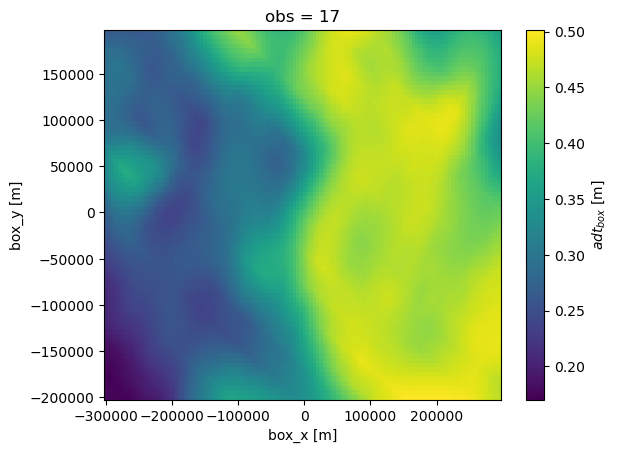

In [31]:
n_obs = 12 # 4 pour avoir NaN, 12 pour avoir limite_lon avec label = 'gps_Jason-3_2019'
obs = res.isel(obs=n_obs)
obs.aviso_box_adt.plot()

In [32]:
# Calculer la taille en mémoire de chaque variable
tailles_variables = {var: res[var].nbytes for var in res.variables}

# Calculer la taille totale du dataset
taille_totale = sum(tailles_variables.values())

print("Tailles des variables individuelles :")
for var, taille in tailles_variables.items():
    print(f"{var}: {taille} bytes")

print(f"Taille totale du dataset : {taille_totale} bytes")
print(f"Taille totale du dataset : {taille_totale / (1024 ** 3)} Go")

Tailles des variables individuelles :
obs: 80000 bytes
box_x: 960 bytes
box_y: 640 bytes
aviso_traj_adt: 119120000 bytes
aviso_traj_err_sla: 119120000 bytes
aviso_traj_sla: 119120000 bytes
drifter_time: 119120000 bytes
drifter_x: 119120000 bytes
drifter_y: 119120000 bytes
aviso_traj_ggx_sla: 119120000 bytes
aviso_traj_ggy_sla: 119120000 bytes
aviso_traj_ggx_adt: 119120000 bytes
aviso_traj_ggy_adt: 119120000 bytes
aviso_drifter_matchup_ggx_sla: 80000 bytes
aviso_drifter_matchup_ggy_sla: 80000 bytes
aviso_drifter_matchup_ggx_adt: 80000 bytes
aviso_drifter_matchup_ggy_adt: 80000 bytes
aviso_box_adt: 768000000 bytes
aviso_box_err_sla: 768000000 bytes
aviso_box_sla: 768000000 bytes
aviso_box_ggx_sla: 768000000 bytes
aviso_box_ggy_sla: 768000000 bytes
aviso_box_ggx_adt: 768000000 bytes
aviso_box_ggy_adt: 768000000 bytes
aviso_drifter_temp_adt: 400000 bytes
aviso_drifter_temp_err_sla: 400000 bytes
aviso_drifter_temp_sla: 400000 bytes
aviso_time_: 400000 bytes
aviso_alti_matchup_adt: 80000 byt